# Pràctica Cas Kaggle 
## CS:GO Competitive Matchmaking Data

### 0. Contexte
#### Què és CS:GO?

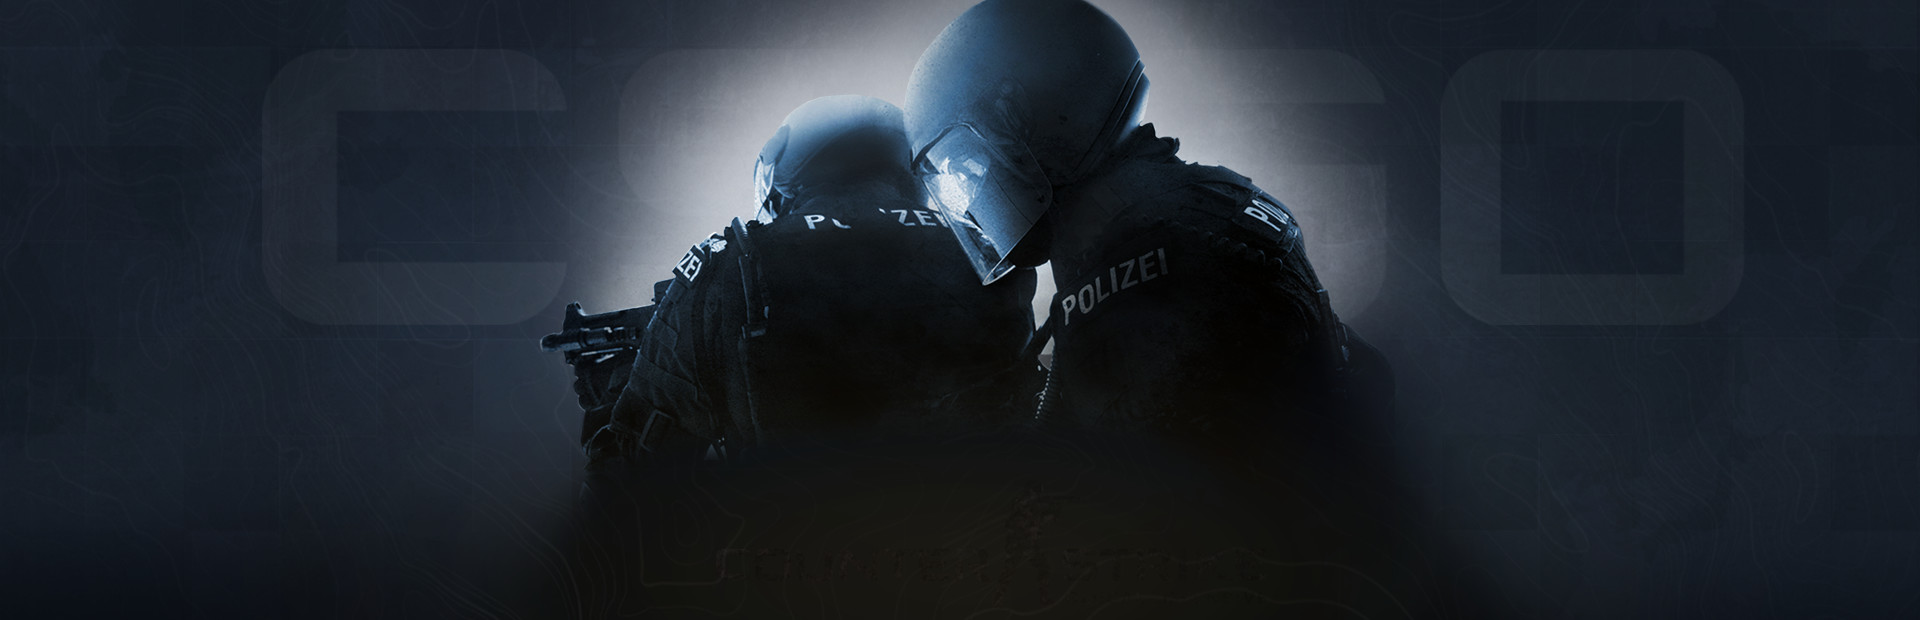

Counter Strike: Global Offensive és un videojoc multijugador gratuit per a ordinadors desenvolupat per Valve Corporation. El mode de joc principal consisteix en que un equip (Terrorists) intenten plantar una bomba en uns punts del mapa mentres que l'altre equip (Counter-Terrorists) intenta evitar-lo, i en cas de que la bomba sigui plantada han de desactivar-la.

Altres regles del joc inclouen:
* En cada equip hi ha 5 jugadors.
* Les partides consisteixen de 30 rondes com a màxim.
* Una ronda s'acaba quan un dels equips asoleix l'objectiu o s'acaba el temps. Si s'acaba el temps, guanyen els Counter-Terrorists.
* A partir de la ronda 15, els equips es canvien i es continua jugant fins que un dels equips aconsegueixi 16 rondes guanyades.

#### Xifres
* És un dels videojocs mes jugats i amb millors ingresos econòmics de la plataforma Steam
* Te un pic de al voltant de **1 millió de jugadors simultanis cada dia** [1]
* S'estima el nombre de jugadors totals entre **270 milions i 677.22 milions**[1]. No es un nombre exacte ja que Steam no revela el nombre de jugadors.
* A Twitch, la plataforma d'streaming de partides de videojocs més importants, va tindre un pic de **1,9 milions d'espectadors simultanis** al novembre de 2021. Moltes vegades está en el top 10 de videojocs mes vists[3]
* // esports....
* // dineros...

[1] Source: https://steamdb.info/app/730/graphs/

[2] Source: https://twitchtracker.com/games/32399

[3] Source: https://www.twitch.tv/directory?sort=VIEWER_COUNT

#### La base de dades

Conté informació de...

### 1. Lectura del dataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score

In [3]:
# Funcions per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# La majoria de les dades estan separades en multiples fitxers. Funcio util per a llegir totes les parts
def load_split_dataset(path, parts):
    dataset = pd.concat([pd.read_csv(path + ".part%d.csv" % x, header=0, delimiter=',') for x in range(1,parts+1)])
    return dataset

#### Dades dels mapes

In [9]:
# Carreguem dades dels mapes
map_data = load_dataset('dataset/map_data.csv')
map_data

,Unnamed: 0,EndX,EndY,ResX,ResY,StartX,StartY
0,de_cache,3752,3187,1024,1024,-2031,-2240
1,de_cbble,2282,3032,1024,1024,-3819,-3073
2,de_dust2,2127,3455,1024,1024,-2486,-1150
3,de_inferno,2797,3800,1024,1024,-1960,-1062
4,de_mirage,1912,1682,1024,1024,-3217,-3401
5,de_overpass,503,1740,1024,1024,-4820,-3591
6,de_train,2262,2447,1024,1024,-2436,-2469


#### Dades de partides: Matchmaking servidors oficials

In [10]:
# Carregar dades de MM
mm_master_demos = load_dataset('dataset/mm_master_demos.csv')
mm_master_demos.head()

mm_grenades_demos = load_dataset('dataset/mm_grenades_demos.csv')
mm_grenades_demos.head()

,Unnamed: 0,file,map,round,start_seconds,seconds,end_seconds,att_team,vic_team,att_id,...,att_pos_x,att_pos_y,nade_land_x,nade_land_y,vic_pos_x,vic_pos_y,round_type,ct_eq_val,t_eq_val,avg_match_rank
0,0,003201673717864202280_0171883906.dem,de_dust2,1,109.5534,125.1816,197.6025,Team 2,NaN,76561198244806730,...,-918.1018,-856.1255,257.32770,-435.8516,NaN,NaN,PISTOL_ROUND,2950,3850,16.0
1,1,003201673717864202280_0171883906.dem,de_dust2,1,109.5534,139.1844,197.6025,Team 2,NaN,76561198051040004,...,-1310.6070,1145.8650,-1124.67500,1216.9330,NaN,NaN,PISTOL_ROUND,2950,3850,16.0
2,2,003201673717864202280_0171883906.dem,de_dust2,1,109.5534,166.0649,197.6025,Team 2,Team 2,76561198147933469,...,-180.6393,327.6691,-89.53781,318.2151,-130.1585,304.0313,PISTOL_ROUND,2950,3850,16.0
3,3,003201673717864202280_0171883906.dem,de_dust2,2,197.6025,213.0431,281.2757,Team 1,NaN,76561198051106390,...,151.3117,2304.8010,-431.48370,2126.3900,NaN,NaN,ECO,12400,4700,16.0
4,4,003201673717864202280_0171883906.dem,de_dust2,2,197.6025,220.8572,281.2757,Team 1,NaN,76561198051106390,...,-1669.9540,2197.1340,-1955.98500,1384.2130,NaN,NaN,ECO,12400,4700,16.0


#### Dades de partides: servidors professionals ESEA https://play.esea.net/

In [23]:
# Carreguem dades de "damage"
#dmg_data = load_split_dataset('dataset/esea_master_dmg_demos', 2)
#dmg_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10538182 entries, 0 to 4546084
Data columns (total 23 columns):
 #   Column           Dtype  
---  ------           -----  
 0   file             object 
 1   round            int64  
 2   tick             int64  
 3   seconds          float64
 4   att_team         object 
 5   vic_team         object 
 6   att_side         object 
 7   vic_side         object 
 8   hp_dmg           int64  
 9   arm_dmg          int64  
 10  is_bomb_planted  bool   
 11  bomb_site        object 
 12  hitbox           object 
 13  wp               object 
 14  wp_type          object 
 15  att_id           int64  
 16  att_rank         int64  
 17  vic_id           int64  
 18  vic_rank         int64  
 19  att_pos_x        float64
 20  att_pos_y        float64
 21  vic_pos_x        float64
 22  vic_pos_y        float64
dtypes: bool(1), float64(5), int64(8), object(9)
memory usage: 1.8+ GB


In [8]:
# Carreguem dades de "grenades"
#grenades_data = load_split_dataset('dataset/esea_master_grenades_demos', 2)
#grenades_data.info()

,file,round,seconds,att_team,vic_team,att_id,vic_id,att_side,vic_side,hp_dmg,...,hitbox,nade,att_rank,vic_rank,att_pos_x,att_pos_y,nade_land_x,nade_land_y,vic_pos_x,vic_pos_y
0,esea_match_13770997.dem,1,153.1602,Animal Style,NaN,76561198165334141,NaN,CounterTerrorist,NaN,0,...,NaN,Smoke,0,NaN,-1618.146,-66.00259,-949.8569,-340.3019,NaN,NaN
1,esea_match_13770997.dem,2,184.7945,Hentai Hooligans,Animal Style,76561198037331400,7.656120e+16,Terrorist,CounterTerrorist,70,...,Generic,HE,0,0.0,-1719.904,-2357.64700,-2774.6650,-1603.9430,-2741.25,-1523.163
2,esea_match_13770997.dem,2,186.8617,Animal Style,NaN,76561198055191021,NaN,CounterTerrorist,NaN,0,...,NaN,HE,0,NaN,-1036.352,492.16760,-466.8676,-356.9641,NaN,NaN
3,esea_match_13770997.dem,2,187.1122,Animal Style,NaN,76561198055054795,NaN,CounterTerrorist,NaN,0,...,NaN,HE,0,NaN,-855.077,438.69090,-459.0147,-543.8581,NaN,NaN
4,esea_match_13770997.dem,2,191.0587,Hentai Hooligans,NaN,76561198037331400,NaN,Terrorist,NaN,0,...,NaN,Molotov,0,NaN,-2617.490,-1832.40700,-2743.5610,-927.2995,NaN,NaN


In [6]:
# Carreguem dataset de kills
#kills_data = load_split_dataset('dataset/esea_master_kills_demos', 2)
#kills_data.head()

,file,round,tick,seconds,att_team,vic_team,att_side,vic_side,wp,wp_type,ct_alive,t_alive,is_bomb_planted
0,esea_match_13770997.dem,1,16058,30.74165,Animal Style,Hentai Hooligans,CounterTerrorist,Terrorist,USP,Pistol,5,4,False
1,esea_match_13770997.dem,1,16210,31.93185,Hentai Hooligans,Animal Style,Terrorist,CounterTerrorist,Glock,Pistol,4,4,False
2,esea_match_13770997.dem,1,16510,34.28094,Hentai Hooligans,Animal Style,Terrorist,CounterTerrorist,Glock,Pistol,3,4,False
3,esea_match_13770997.dem,1,17104,38.93212,Animal Style,Hentai Hooligans,CounterTerrorist,Terrorist,USP,Pistol,3,3,False
4,esea_match_13770997.dem,1,17338,40.76441,Hentai Hooligans,Animal Style,Terrorist,CounterTerrorist,Glock,Pistol,2,3,False


In [11]:
# Carreguem dades de "meta"
meta_data = load_split_dataset('dataset/esea_meta_demos', 2)
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377629 entries, 0 to 161709
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   file           377629 non-null  object 
 1   map            377629 non-null  object 
 2   round          377629 non-null  int64  
 3   start_seconds  377589 non-null  float64
 4   end_seconds    377589 non-null  float64
 5   winner_team    377628 non-null  object 
 6   winner_side    377629 non-null  object 
 7   round_type     377629 non-null  object 
 8   ct_eq_val      377629 non-null  int64  
 9   t_eq_val       377629 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 31.7+ MB


### 2. Anàlisi de les dades

In [ ]:
# TODO: preprocesament:
# eliminar outliers? mirar correlacions y todo

In [26]:
# Mostrar tots els equips
meta_data['winner_team'].value_counts()

Team 1                  192564
Team 2                  184262
Team Kinguin                74
Izako Boars                 57
PRiDE                       49
MVP PK                      48
ALTERNATE aTTaX             46
--to be determined--        41
SZ Absolute                 41
EURONICS Gaming             32
Ground Zero                 32
Sprout                      32
AGO Esports                 32
Chiefs                      32
Grayhound                   31
Endpoint                    31
PACT                        27
Dynasty                     25
BOOT-dS Letou               24
SYF                         22
FlashGaming                 19
Legacy                      16
Hentai Hooligans            15
Guerrilla Tactics           15
Taboo                       14
x-kom Team                  11
Animal Style                 9
ONCA Gaming                  8
fish123                      8
Cerus eSports                7
anime savants                4
Name: winner_team, dtype: int64

Hi ha un parell d'equips que son placeholders perque no s'ha registrat quin equip ha guanyat. Aixo fa que no sigui usable, eliminem.

In [30]:
# Eliminem columna
meta_data.drop('winner_team', axis=1)

,file,map,round,start_seconds,end_seconds,winner_side,round_type,ct_eq_val,t_eq_val
0,esea_match_13770997.dem,de_overpass,1,94.30782,160.9591,Terrorist,PISTOL_ROUND,4300,4250
1,esea_match_13770997.dem,de_overpass,2,160.95910,279.3998,Terrorist,ECO,6300,19400
2,esea_match_13770997.dem,de_overpass,3,279.39980,341.0084,Terrorist,SEMI_ECO,7650,19250
3,esea_match_13770997.dem,de_overpass,4,341.00840,435.4259,Terrorist,NORMAL,24900,23400
4,esea_match_13770997.dem,de_overpass,5,435.42590,484.2398,CounterTerrorist,ECO,5400,20550
...,...,...,...,...,...,...,...,...,...
161705,esea_match_13829173.dem,de_mirage,18,1647.20600,1694.6550,Terrorist,ECO,4500,21950
161706,esea_match_13829173.dem,de_mirage,19,1694.65500,1753.4380,Terrorist,NORMAL,16400,26100
161707,esea_match_13829173.dem,de_mirage,20,1753.43800,1803.6580,Terrorist,FORCE_BUY,15100,26000
161708,esea_match_13829173.dem,de_mirage,21,1803.65800,1856.0850,Terrorist,NORMAL,17550,25500


<AxesSubplot:ylabel='winner_side'>

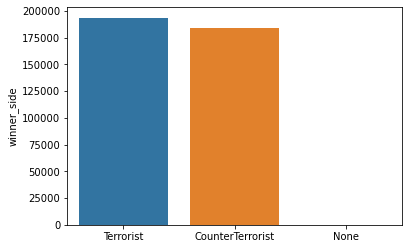

In [22]:
# Quin equip (side) guanya mes?
side_counts = meta_data['winner_side'].value_counts()
sns.barplot(x=side_counts.index, y=side_counts)

array([[<AxesSubplot:title={'center':'round'}>,
        <AxesSubplot:title={'center':'start_seconds'}>],
       [<AxesSubplot:title={'center':'end_seconds'}>,
        <AxesSubplot:title={'center':'ct_eq_val'}>],
       [<AxesSubplot:title={'center':'t_eq_val'}>, <AxesSubplot:>]],
      dtype=object)

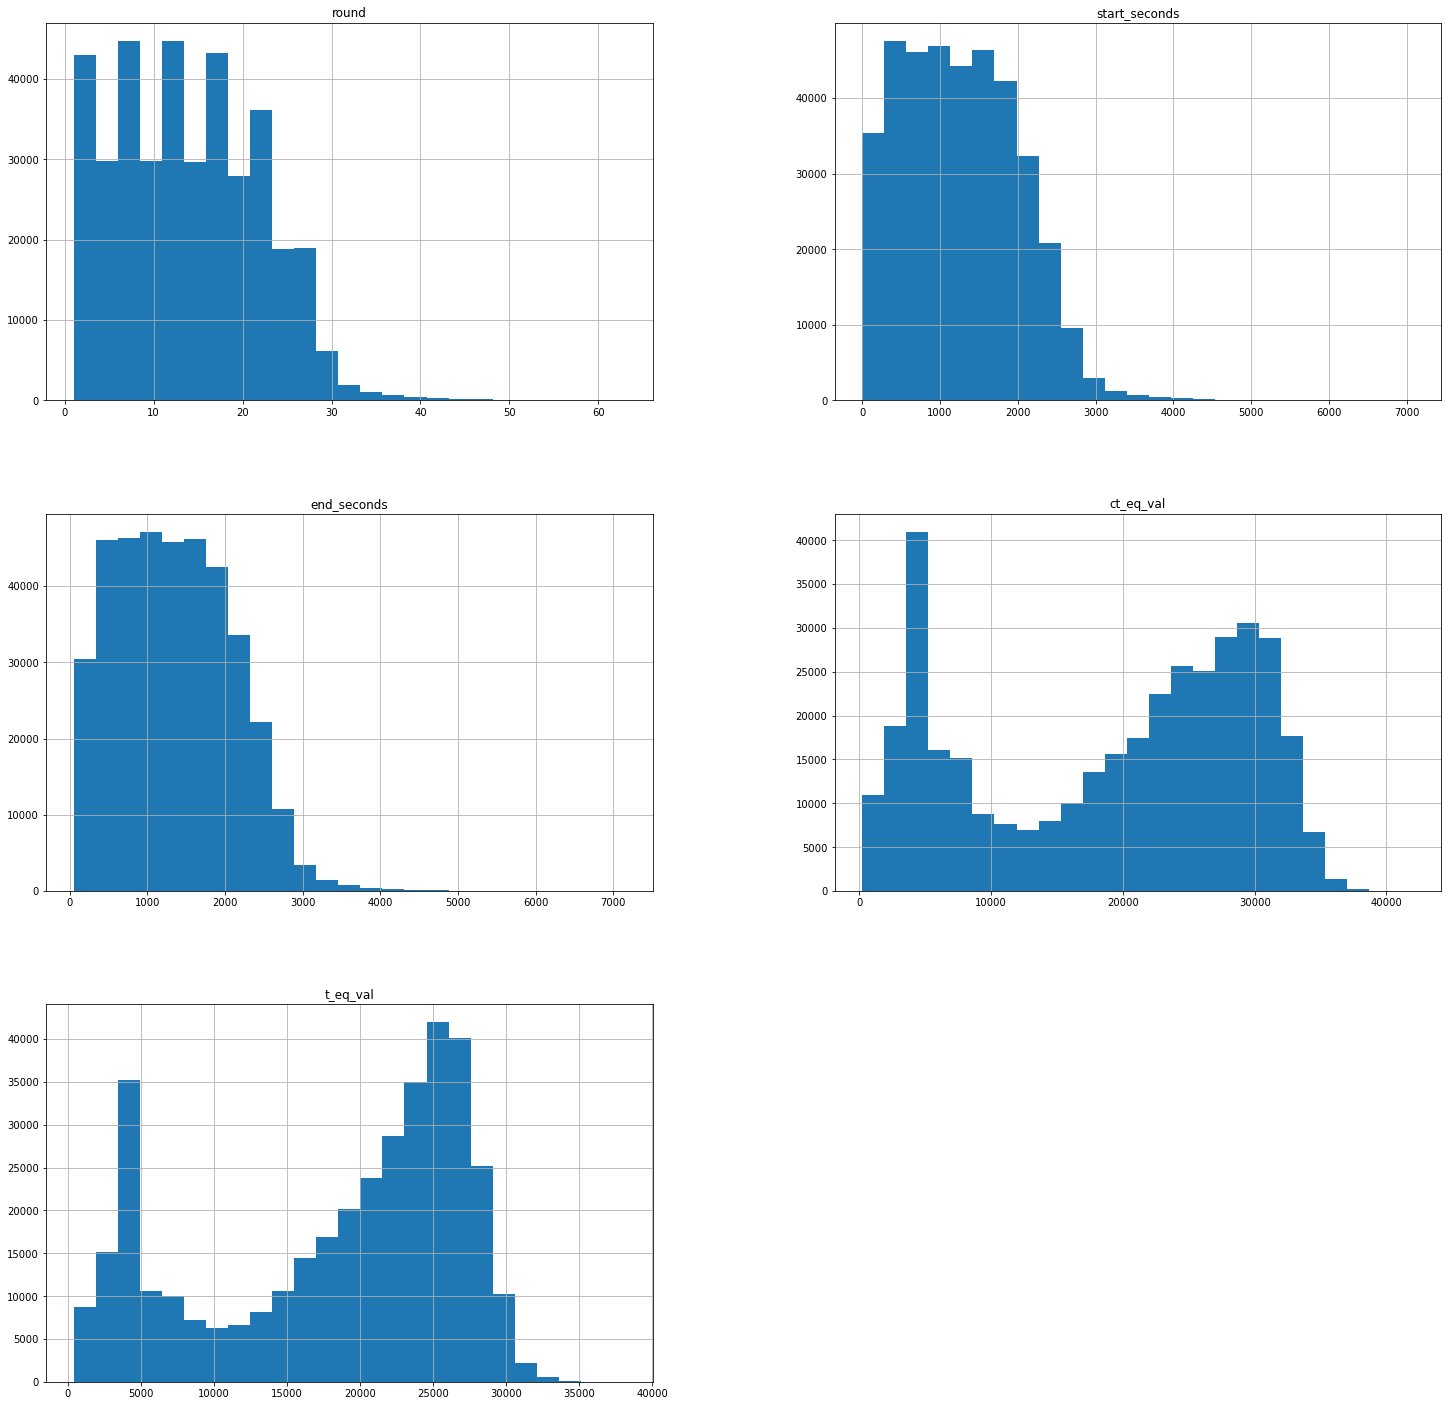

In [31]:
# Generar histogrames, general
meta_data.hist(bins=25, figsize=(25, 25))